In [1]:
!pip install numpy_groupies
!pip install rechunker

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41649")
client

<Client: 'tcp://127.0.0.1:41649' processes=8 threads=32, memory=125.81 GiB>

In [244]:
client.restart()

<Client: 'tcp://127.0.0.1:41649' processes=7 threads=28, memory=110.09 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [104]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'y':200,'x':200})
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'y':200,'x':200})
enatl01w

<xarray.Dataset>
Dimensions:        (time_counter: 2136, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 200, 200), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>

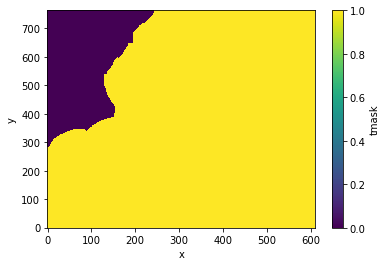

In [238]:
mask = enatl01w.tmask.copy().reset_coords(drop=True)
# mask.isel(y=slice(500,None),x=slice(None,150))[:] = 0.
# mask.isel(y=slice(650,None),x=slice(None,230))[:] = 0.
mask[500:,:130] = 0.
mask[570:,:150] = 0.
mask[650:,:195] = 0.
mask.plot()

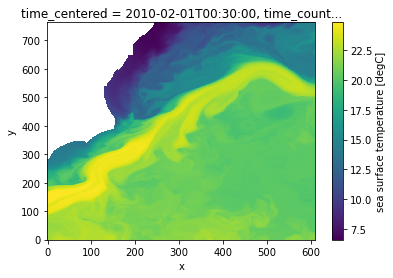

In [142]:
enatl01w.sosstsst.isel(time_counter=0).where(mask!=0.).plot()

In [44]:
test = xr.DataArray(range(10), dims='x')
test-test.shift(x=3)

<xarray.DataArray (x: 10)>
array([nan, nan, nan,  3.,  3.,  3.,  3.,  3.,  3.,  3.])
Dimensions without coordinates: x

# Zonal and meri. structure function

In [155]:
N = 300
num = 30
np.logspace(1, np.log10(N), num=num).astype(int)

array([ 10,  11,  12,  14,  15,  17,  20,  22,  25,  28,  32,  36,  40,
        45,  51,  58,  65,  73,  82,  92, 104, 117, 132, 148, 166, 187,
       211, 237, 266, 300])

In [156]:
SFx_1w = xr.ones_like(enatl01w.sosstsst.isel(x=slice(None,num))).reset_coords(drop=True).load() * np.nan
SFy_1w = xr.ones_like(enatl01w.sosstsst.isel(y=slice(None,num))).reset_coords(drop=True).load() * np.nan
j = 0
for i in np.logspace(1, np.log10(N), num=num).astype(int):
    
    SFx_1w[...,j] = np.abs(enatl01w.sosstsst.where(mask!=0.) 
                           - enatl01w.sosstsst.where(mask!=0.).shift(x=int(i))
                          ).reset_coords(drop=True).mean('x', skipna=True)
    SFy_1w[:,j] = np.abs(enatl01w.sosstsst.where(mask!=0.) 
                         - enatl01w.sosstsst.where(mask!=0.).shift(y=int(i))
                        ).reset_coords(drop=True).mean('y', skipna=True)

    j += 1
    
SFx_1w

<xarray.DataArray 'sosstsst' (time_counter: 2136, y: 763, x: 30)>
array([[[0.21647154, 0.23002642, 0.24315393, ..., 0.6854427 ,
         0.6302645 , 0.6339573 ],
        [0.22565845, 0.23863393, 0.25133905, ..., 0.6899364 ,
         0.6254298 , 0.61836797],
        [0.22972135, 0.24306923, 0.255685  , ..., 0.6913415 ,
         0.6225933 , 0.60539484],
        ...,
        [0.5455234 , 0.58413565, 0.61953956, ..., 2.7235887 ,
         3.733352  , 5.631086  ],
        [0.56446517, 0.6017698 , 0.6363628 , ..., 2.6255224 ,
         3.5838249 , 5.503178  ],
        [0.55725044, 0.59126365, 0.62342185, ..., 2.5016932 ,
         3.3932457 , 5.27685   ]],

       [[0.21697828, 0.23014551, 0.24295866, ..., 0.68688434,
         0.6322328 , 0.6365197 ],
        [0.22600713, 0.23876035, 0.25153825, ..., 0.6913714 ,
         0.62919605, 0.62198955],
        [0.22883314, 0.2421952 , 0.2548416 , ..., 0.6927212 ,
         0.6262401 , 0.61184686],
...
        [0.48164496, 0.51728576, 0.5511969 , ..., 6.5398965 ,
         7.8608    , 8.564196  ],
        [0.48138693, 0.5150045 , 0.547206  , ..., 6.138952  ,
         7.5684524 , 8.521293  ],
        [0.4809924 , 0.5153495 , 0.5484042 , ..., 5.6027756 ,
         7.1089954 , 8.474888  ]],

       [[0.19676444, 0.21391296, 0.23075935, ..., 1.1971679 ,
         1.2661148 , 1.398033  ],
        [0.19503558, 0.21244353, 0.2294011 , ..., 1.1972908 ,
         1.2648934 , 1.399873  ],
        [0.19270971, 0.2101593 , 0.22725919, ..., 1.1992201 ,
         1.2657355 , 1.4054755 ],
        ...,
        [0.48769364, 0.52238834, 0.55621773, ..., 6.5825086 ,
         7.902055  , 8.6185255 ],
        [0.49221563, 0.5259285 , 0.55743605, ..., 6.168261  ,
         7.6002293 , 8.577288  ],
        [0.48729208, 0.5224743 , 0.5559827 , ..., 5.643471  ,
         7.15644   , 8.532709  ]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
Dimensions without coordinates: y, x

In [157]:
SFx_1s = xr.ones_like(enatl01s.sosstsst.isel(x=slice(None,num))).reset_coords(drop=True).load() * np.nan
SFy_1s = xr.ones_like(enatl01s.sosstsst.isel(y=slice(None,num))).reset_coords(drop=True).load() * np.nan
j = 0
for i in np.logspace(1, np.log10(N), num=num).astype(int):
    
    SFx_1s[...,j] = np.abs(enatl01s.sosstsst.where(mask!=0.) 
                           - enatl01s.sosstsst.where(mask!=0.).shift(x=int(i))
                          ).reset_coords(drop=True).mean('x', skipna=True)
    SFy_1s[:,j] = np.abs(enatl01s.sosstsst.where(mask!=0.) 
                         - enatl01s.sosstsst.where(mask!=0.).shift(y=int(i))
                        ).reset_coords(drop=True).mean('y', skipna=True)

    j += 1
    
SFx_1s

<xarray.DataArray 'sosstsst' (time_counter: 1464, y: 763, x: 30)>
array([[[0.10251302, 0.11067782, 0.11891484, ..., 0.40285257,
         0.4158118 , 0.40602848],
        [0.103515  , 0.11162481, 0.11987567, ..., 0.41430742,
         0.4236147 , 0.41245523],
        [0.10495731, 0.11296219, 0.12100415, ..., 0.42446697,
         0.43117565, 0.41672102],
        ...,
        [0.7542622 , 0.8157809 , 0.87481064, ..., 3.620948  ,
         3.0047786 , 2.3312309 ],
        [0.755541  , 0.81667167, 0.87593186, ..., 3.512794  ,
         2.8986254 , 2.3062458 ],
        [0.75835675, 0.8191012 , 0.8783301 , ..., 3.396104  ,
         2.7855663 , 2.2787416 ]],

       [[0.10340293, 0.11195582, 0.12024848, ..., 0.400698  ,
         0.41334796, 0.40205663],
        [0.10474574, 0.11313418, 0.12151781, ..., 0.41247538,
         0.42150906, 0.40888202],
        [0.10643611, 0.11463374, 0.1229561 , ..., 0.4226889 ,
         0.42934313, 0.41342375],
...
        [0.47279447, 0.50296915, 0.5290333 , ..., 2.6879535 ,
         3.0140615 , 2.7778096 ],
        [0.47559226, 0.50616705, 0.5343422 , ..., 2.677119  ,
         3.0152993 , 2.7784803 ],
        [0.4822418 , 0.51458806, 0.5457931 , ..., 2.653497  ,
         3.011662  , 2.7793407 ]],

       [[0.08189359, 0.08882   , 0.09561023, ..., 0.6784141 ,
         0.7549853 , 0.88910294],
        [0.08275119, 0.08986124, 0.09678736, ..., 0.6761857 ,
         0.75144655, 0.88329065],
        [0.08346404, 0.09068623, 0.09777018, ..., 0.6732783 ,
         0.74743986, 0.8763317 ],
        ...,
        [0.47219375, 0.5016314 , 0.52802247, ..., 2.6970587 ,
         3.0216825 , 2.7827249 ],
        [0.47440192, 0.5040335 , 0.5321089 , ..., 2.6873567 ,
         3.023319  , 2.7844877 ],
        [0.47953677, 0.5113895 , 0.5414809 , ..., 2.6650653 ,
         3.0208166 , 2.7860823 ]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...
Dimensions without coordinates: y, x

In [158]:
SFx_2w = xr.ones_like(enatl01w.sosstsst.isel(x=slice(None,num))).reset_coords(drop=True).load() * np.nan
SFy_2w = xr.ones_like(enatl01w.sosstsst.isel(y=slice(None,num))).reset_coords(drop=True).load() * np.nan

j = 0
for i in np.logspace(1, np.log10(N), num=num).astype(int):
    
    SFx_2w[...,j] = ((enatl01w.sosstsst.where(mask!=0.) 
                      - enatl01w.sosstsst.where(mask!=0.).shift(x=int(i)))**2
                    ).reset_coords(drop=True).mean('x', skipna=True)
    SFy_2w[:,j] = ((enatl01w.sosstsst.where(mask!=0.) 
                    - enatl01w.sosstsst.where(mask!=0.).shift(y=int(i)))**2
                  ).reset_coords(drop=True).mean('y', skipna=True)

    j += 1
    
SFx_2w

<xarray.DataArray 'sosstsst' (time_counter: 2136, y: 763, x: 30)>
array([[[ 0.09695072,  0.10727105,  0.11732174, ...,  0.6585465 ,
          0.5826484 ,  0.6422092 ],
        [ 0.10437813,  0.11510426,  0.12537687, ...,  0.65120834,
          0.57447165,  0.6095952 ],
        [ 0.10764545,  0.118738  ,  0.12926832, ...,  0.6409411 ,
          0.5657189 ,  0.58724046],
        ...,
        [ 0.75431675,  0.8434978 ,  0.9291662 , ...,  9.204053  ,
         15.095239  , 32.610447  ],
        [ 0.7920048 ,  0.8787287 ,  0.95793706, ...,  9.023463  ,
         14.21371   , 31.168213  ],
        [ 0.7141212 ,  0.7904479 ,  0.8650179 , ...,  8.768435  ,
         13.115248  , 28.732706  ]],

       [[ 0.09807538,  0.10828947,  0.11821935, ...,  0.66115034,
          0.58802736,  0.6426015 ],
        [ 0.10528631,  0.11598366,  0.12618674, ...,  0.654851  ,
          0.581427  ,  0.6139139 ],
        [ 0.10655342,  0.1177032 ,  0.12826675, ...,  0.6451868 ,
          0.57352924,  0.59603465],
...
        [ 0.47005543,  0.5428484 ,  0.6174721 , ..., 48.488247  ,
         66.397835  , 75.85887   ],
        [ 0.44439852,  0.5105741 ,  0.5781177 , ..., 45.221912  ,
         63.56812   , 75.18654   ],
        [ 0.529766  ,  0.61773634,  0.7096566 , ..., 41.869457  ,
         60.346333  , 74.462135  ]],

       [[ 0.08670264,  0.09970133,  0.11298237, ...,  1.8084992 ,
          1.8551391 ,  2.4522278 ],
        [ 0.08640874,  0.09947667,  0.11290405, ...,  1.8152646 ,
          1.8632169 ,  2.4888837 ],
        [ 0.08664326,  0.09989493,  0.11354428, ...,  1.8288182 ,
          1.880585  ,  2.5352056 ],
        ...,
        [ 0.48722905,  0.56260794,  0.63978004, ..., 48.996223  ,
         67.05777   , 76.75367   ],
        [ 0.464437  ,  0.5323764 ,  0.60162914, ..., 45.618515  ,
         64.18533   , 76.101906  ],
        [ 0.5423056 ,  0.6311997 ,  0.72427034, ..., 42.355667  ,
         61.105755  , 75.4018    ]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
Dimensions without coordinates: y, x

In [159]:
SFx_2s = xr.ones_like(enatl01s.sosstsst.isel(x=slice(None,num))).reset_coords(drop=True).load() * np.nan
SFy_2s = xr.ones_like(enatl01s.sosstsst.isel(y=slice(None,num))).reset_coords(drop=True).load() * np.nan

j = 0
for i in np.logspace(1, np.log10(N), num=num).astype(int):
    
    SFx_2s[...,j] = ((enatl01s.sosstsst.where(mask!=0.) 
                      - enatl01s.sosstsst.where(mask!=0.).shift(x=int(i)))**2
                    ).reset_coords(drop=True).mean('x', skipna=True)
    SFy_2s[:,j] = ((enatl01s.sosstsst.where(mask!=0.) 
                    - enatl01s.sosstsst.where(mask!=0.).shift(y=int(i)))**2
                  ).reset_coords(drop=True).mean('y', skipna=True)

    j += 1
    
SFx_2s

<xarray.DataArray 'sosstsst' (time_counter: 1464, y: 763, x: 30)>
array([[[2.10925527e-02, 2.42514163e-02, 2.74738614e-02, ...,
         2.31438115e-01, 2.59809434e-01, 2.43748575e-01],
        [2.17914321e-02, 2.50346493e-02, 2.83375103e-02, ...,
         2.44562134e-01, 2.68550932e-01, 2.50626057e-01],
        [2.24879887e-02, 2.58150939e-02, 2.91995071e-02, ...,
         2.56814510e-01, 2.75965810e-01, 2.55150020e-01],
        ...,
        [2.08169627e+00, 2.34914398e+00, 2.61613131e+00, ...,
         1.63583984e+01, 1.27613163e+01, 7.03955936e+00],
        [2.05074906e+00, 2.31282616e+00, 2.57581782e+00, ...,
         1.55747128e+01, 1.20524321e+01, 6.97298384e+00],
        [2.00842714e+00, 2.26617122e+00, 2.52518082e+00, ...,
         1.47384939e+01, 1.13119946e+01, 6.86627579e+00]],

       [[2.14621145e-02, 2.47062165e-02, 2.80293599e-02, ...,
         2.25628600e-01, 2.54954308e-01, 2.38424152e-01],
        [2.22173389e-02, 2.55424604e-02, 2.89404392e-02, ...,
         2.39691034e-01, 2.64329404e-01, 2.45632187e-01],
        [2.29330733e-02, 2.63358057e-02, 2.98073813e-02, ...,
         2.53015906e-01, 2.72332579e-01, 2.50410795e-01],
...
        [4.13427174e-01, 4.64803427e-01, 5.14120817e-01, ...,
         9.80862427e+00, 1.26161776e+01, 1.27811260e+01],
        [4.25305456e-01, 4.79791075e-01, 5.32137871e-01, ...,
         9.76412964e+00, 1.25407543e+01, 1.28074532e+01],
        [4.38778460e-01, 4.96988833e-01, 5.53234875e-01, ...,
         9.64982986e+00, 1.24195404e+01, 1.27757816e+01]],

       [[1.43503724e-02, 1.66296680e-02, 1.90395340e-02, ...,
         6.19405627e-01, 7.27264464e-01, 8.91824305e-01],
        [1.43279731e-02, 1.66051779e-02, 1.90149117e-02, ...,
         6.13939703e-01, 7.20132470e-01, 8.84386659e-01],
        [1.43575286e-02, 1.66391041e-02, 1.90536287e-02, ...,
         6.07383966e-01, 7.12201357e-01, 8.75096738e-01],
        ...,
        [4.10949618e-01, 4.61624801e-01, 5.10279119e-01, ...,
         9.87171173e+00, 1.27229939e+01, 1.28017941e+01],
        [4.21381384e-01, 4.74969119e-01, 5.26391327e-01, ...,
         9.83389187e+00, 1.26437769e+01, 1.28523874e+01],
        [4.34108794e-01, 4.91323590e-01, 5.46497881e-01, ...,
         9.73021221e+00, 1.25239906e+01, 1.28397446e+01]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...
Dimensions without coordinates: y, x

In [160]:
dx = xr.ones_like(enatl01w.sosstsst.isel(time_counter=0,x=slice(None,num))).reset_coords(drop=True).load() * np.nan
dy = xr.ones_like(enatl01w.sosstsst.isel(time_counter=0,y=slice(None,num))).reset_coords(drop=True).load() * np.nan
j = 0
for i in np.logspace(1, np.log10(N), num=num).astype(int):
    
    dx[:,j] = enatl01w.e1t.where(enatl01w.tmask!=0.).coarsen(x=int(i), boundary='trim').sum('x',skipna=True).mean('x',skipna=True)
    dy[j] = enatl01w.e2t.where(enatl01w.tmask!=0.).coarsen(y=int(i), boundary='trim').sum('y',skipna=True).mean('y',skipna=True)
    
    j += 1

dx

<xarray.DataArray 'sosstsst' (y: 763, x: 30)>
array([[ 16047.216,  17651.947,  19256.682, ..., 380325.16 , 426859.9  ,
        481417.06 ],
       [ 16044.923,  17649.426,  19253.93 , ..., 380270.84 , 426798.94 ,
        481348.25 ],
       [ 16042.63 ,  17646.904,  19251.18 , ..., 380216.53 , 426737.94 ,
        481279.47 ],
       ...,
       [  8520.987,   9321.47 ,  10111.627, ..., 163331.23 , 204512.5  ,
        252790.69 ],
       [  8519.49 ,   9319.831,  10109.85 , ..., 163302.53 , 204476.55 ,
        252746.25 ],
       [  8517.99 ,   9318.19 ,  10108.07 , ..., 163273.8  , 204440.56 ,
        252701.77 ]], dtype=float32)
Dimensions without coordinates: y, x

(10.0, 477.3021232196403)

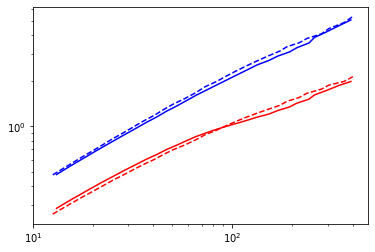

In [161]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()

ax.plot(dx.mean('y')*1e-3, SFx_1s.mean(['time_counter','y']), 'r', label='')
ax.plot(dy.mean('x')*1e-3, SFy_1s.mean(['time_counter','x']), 'r--')
ax.plot(dx.mean('y')*1e-3, SFx_1w.mean(['time_counter','y']), 'b')
ax.plot(dy.mean('x')*1e-3, SFy_1w.mean(['time_counter','x']), 'b--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1,None])
ax.set_legend(loc='upper left')

(10.0, 477.3021232196403)

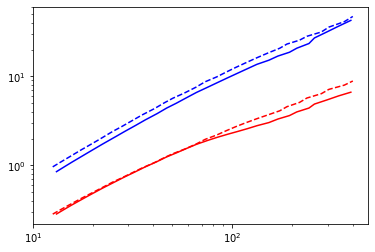

In [162]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()

ax.plot(dx.mean('y')*1e-3, SFx_2s.mean(['time_counter','y']), 'r')
ax.plot(dy.mean('x')*1e-3, SFy_2s.mean(['time_counter','x']), 'r--')
ax.plot(dx.mean('y')*1e-3, SFx_2w.mean(['time_counter','y']), 'b')
ax.plot(dy.mean('x')*1e-3, SFy_2w.mean(['time_counter','x']), 'b--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1,None])

# Isotropic structure function

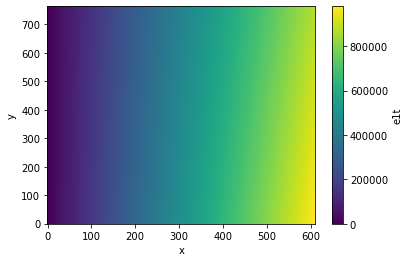

In [168]:
Lx = enatl01w.e1t.cumsum('x', skipna=True)
Ly = enatl01w.e2t.cumsum('y', skipna=True)
Lx = Lx - Lx.isel(x=0)
Ly = Ly - Ly.isel(y=0)
Lx.plot()

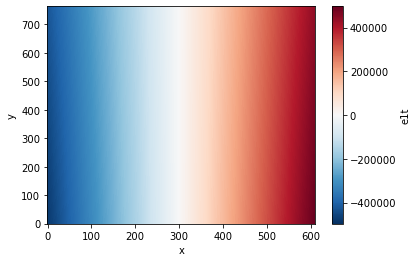

In [167]:
(Lx - Lx.isel(x=300)).plot()

In [169]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


In [221]:
test = xr.DataArray(np.random.rand(20,30), dims=['y','x'],
                    coords={'y':np.arange(-10,10), 'x':np.arange(-15,15)}
                   )

N = test.shape
nfactor = 3
nbins = int(min(N) / nfactor)
rr = np.sqrt(test.y ** 2 + test.x ** 2).rename("rr")
R = _groupby_bins_agg(rr, rr, bins=nbins, func="mean")
if test.x.max() > test.y.max():
    Rmax = test.y.max()
else:
    Rmax = test.x.max()
R = R.where(R <= Rmax)

binned = pd.cut(np.ravel(rr), nbins)
new_dim_name = rr.name + "_bins"
indices = rr.copy(data=binned.codes.reshape(rr.shape))
indices

<xarray.DataArray 'rr' (y: 20, x: 30)>
array([[5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 5, 5, 5],
       [5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 5, 5],
       [5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 4, 4, 4, 4, 5, 5],
       [5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 4, 4, 4, 4, 5],
       [5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 4, 4, 4, 5],
       [5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 3, 3, 3, 4, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        2, 2, 2, 3, 3, 3, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 3, 3, 3, 4, 4, 4],
       [5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 3, 3, 3, 4, 4, 4, 4],
       [5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 4, 4, 4, 5],
       [5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 4, 4, 4, 4, 5],
       [5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 4, 4, 4, 4, 5, 5],
       [5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 5, 5]], dtype=int8)
Coordinates:
  * y        (y) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9
  * x        (x) int64 -15 -14 -13 -12 -11 -10 -9 -8 -7 ... 7 8 9 10 11 12 13 14

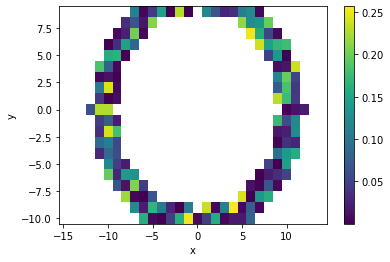

In [226]:
((test.where(indices==0).mean(skipna=True) - test.where(indices==3))**2).plot()

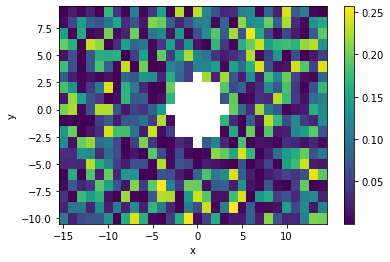

In [228]:
((test.where(indices==0).mean(skipna=True) - test.where(indices!=0.))**2).plot()

In [232]:
((test.where(indices==0).mean(skipna=True) - test.where(indices!=0.))**2).groupby(indices).mean()

<xarray.DataArray (rr: 6)>
array([       nan, 0.07613901, 0.09152933, 0.08562103, 0.08540329,
       0.0828292 ])
Coordinates:
  * rr       (rr) int64 0 1 2 3 4 5

In [227]:
mask = np.logical_not(np.isnan(indices))
int_indices = indices[mask].astype(int)
shape = test.shape[: -indices.ndim] + (nbins,)
shape

IndexError: 2-dimensional boolean indexing is not supported. 

In [236]:
isoSF2w = xr.DataArray(np.ones((len(enatl01w.time_counter), nbins)),
                       dims=['time_counter','r'],
                       coords={'time_counter':enatl01w.time_counter, 'r':dr}
                      ) * np.nan
isoSF2s = xr.DataArray(np.ones((len(enatl01s.time_counter), nbins)),
                       dims=['time_counter','r'],
                       coords={'time_counter':enatl01s.time_counter, 'r':dr}
                      ) * np.nan

In [243]:
rr = np.sqrt((Ly - Ly.isel(y=int(.5*len(Ly)))) ** 2 + (Lx - Lx.isel(x=int(.5*len(Lx)))) ** 2).rename("rr")
R = _groupby_bins_agg(rr, rr, bins=nbins, func="mean")
if (Lx - Lx.isel(x=int(.5*len(Lx)))).max() > (Ly - Ly.isel(y=int(.5*len(Ly)))).max():
    Rmax = (Ly - Ly.isel(y=int(.5*len(Ly)))).max()
else:
    Rmax = (Lx - Lx.isel(x=int(.5*len(Lx)))).max()
R = R.where(R <= Rmax).compute()

# dr = np.sqrt((dx**2).mean('y',skipna=True).data + (dy**2).mean('x',skipna=True).data)
# dr
R

<xarray.DataArray 'rr' (rr_bins: 40)>
array([ 13896.29189805,  32485.09265263,  52952.20812294,  73681.11137253,
        94449.1732904 , 115244.55244617, 136115.39045398, 157002.9139454 ,
       177887.5022971 , 198764.11455786, 219630.54708724, 240514.27403522,
       261413.03557134, 282310.68555766, 303194.61092413, 324087.39523669,
       344858.15232428, 365763.41852421,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * rr_bins  (rr_bins) object (-836.064, 20901.611] ... (815162.832, 836064.443]

In [259]:
# Nr = 16
# phis = np.linspace(0,2*np.pi,Nr, endpoint=False)


# ddd = 0
# for dd in np.logspace(1, np.log10(N), num=num).astype(int):
    
#     skipd = 1.5e2/dd
#     if skipd < 1.:
#         skipd = 1.

jj = 0
for j in range(100,len(Ly.y),200):
    ii = 0
    for i in range(100,len(Lx.x),200):

        isoSF2wxy = np.ones((len(enatl01w.time_counter),
                             nbins,
                             len(np.arange(100,len(Ly.y),200)),
                             len(np.arange(100,len(Lx.x),200))
                            )) * np.nan
        isoSF2sxy = np.ones((len(enatl01s.time_counter),
                             nbins,
                             len(np.arange(100,len(Ly.y),200)),
                             len(np.arange(100,len(Lx.x),200))
                            )) * np.nan
        
        
        ssts = xr.DataArray((enatl01s.sosstsst.where(mask!=0.)
                             - enatl01s.sosstsst.where(mask!=0.).mean(['y','x'],skipna=True)).data,
                            dims=enatl01s.sosstsst.dims,
                            coords={'time_counter':enatl01s.time_counter,
                                    'y':(Ly-Ly.isel(y=j)).mean('x'),
                                    'x':(Lx-Lx.isel(x=i)).mean('y')
                                    }
        )
        sstw = xr.DataArray((enatl01w.sosstsst.where(mask!=0.)
                             - enatl01w.sosstsst.where(mask!=0.).mean(['y','x'],skipna=True)).data,
                            dims=enatl01w.sosstsst.dims,
                            coords={'time_counter':enatl01w.time_counter,
                                    'y':(Ly-Ly.isel(y=j)).mean('x'),
                                    'x':(Lx-Lx.isel(x=i)).mean('y')
                                    }
        )
#             r = xr.DataArray(np.sqrt((Lx-Lx.isel(x=i)).mean('y').data**2 
#                                      + (Ly-Ly.isel(y=j)).mean('x').data**2),
#                              dims=Ly.dims, coords=Ly.coords
#             )
        rr = np.sqrt(ssts.y ** 2 + ssts.x ** 2).rename("rr")
        binned = pd.cut(np.ravel(rr), nbins)
        new_dim_name = rr.name + "_bins"
        indices = rr.copy(data=binned.codes.reshape(rr.shape))
            
#             tmpw = np.ones((len(enatl01w.time_counter),nbins)) * np.nan
#             tmps = np.ones((len(enatl01s.time_counter),nbins)) * np.nan

#             for ph in range(Nr):

#                 xx = dr[ddd]*np.cos(phis[ph])
#                 yy = dr[ddd]*np.sin(phis[ph])
                
#                 if ssts.x.isel(x=i)+xx <= ssts.x.max() and ssts.y.isel(y=j)+yy <= ssts.y.max():
#                     tmpw[:,ph] = (sstw.isel(y=j,x=i) 
#                                   - sstw.sel(y=yy,method='nearest').sel(x=xx,method='nearest').data
#                                  )**2
#                     tmps[:,ph] = (ssts.isel(y=j,x=i) 
#                                   - ssts.sel(y=yy,method='nearest').sel(x=xx,method='nearest').data
#                                  )**2
            
                    
        isoSF2wxy[...,jj,ii] = ((sstw.where(indices==0).mean(skipna=True) 
                                 - sstw.where(indices!=0.))**2
                               ).groupby(indices).mean(skipna=True)
        isoSF2sxy[...,jj,ii] = ((ssts.where(indices==0).mean(skipna=True) 
                                 - ssts.where(indices!=0.))**2
                               ).groupby(indices).mean(skipna=True)
        
        del ssts
        del sstw
            
        ii += 1
    jj += 1

In [260]:
isoSF2w = xr.DataArray(np.nanmean(isoSF2wxy, axis=(-1,-2)),
                       dims=['time_counter','r'],
                       coords={'time_counter':enatl01w.time_counter, 'r':R.data}
                      )
isoSF2s = xr.DataArray(np.nanmean(isoSF2sxy, axis=(-1,-2)),
                       dims=['time_counter','r'],
                       coords={'time_counter':enatl01s.time_counter, 'r':R.data}
                      )
isoSF2w

/tmp/ipykernel_6919/2853299810.py:1: RuntimeWarning: Mean of empty slice
  isoSF2w = xr.DataArray(np.nanmean(isoSF2wxy, axis=(-1,-2)),
/tmp/ipykernel_6919/2853299810.py:5: RuntimeWarning: Mean of empty slice
  isoSF2s = xr.DataArray(np.nanmean(isoSF2sxy, axis=(-1,-2)),


<xarray.DataArray (time_counter: 2136, r: 40)>
array([[        nan,  0.95409328,  4.59058523, ..., 56.43858719,
        57.71401978, 59.80487442],
       [        nan,  0.94234151,  4.5485158 , ..., 56.42414856,
        58.02156067, 59.73774719],
       [        nan,  0.93071079,  4.5038271 , ..., 56.43267822,
        58.34748077, 59.62346268],
       ...,
       [        nan,  6.23520279,  4.80703545, ..., 69.37689209,
        76.10079956, 70.55493164],
       [        nan,  6.2488966 ,  4.87130785, ..., 69.4754715 ,
        76.34169006, 70.92193604],
       [        nan,  6.28943968,  4.92337656, ..., 69.55951691,
        76.49369812, 71.14228058]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
  * r             (r) float64 1.39e+04 3.249e+04 5.295e+04 ... nan nan nan

Text(0, 0.5, '[$^\\circ$C$^2$]')

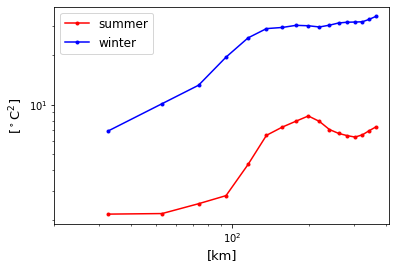

In [266]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()

ax.plot(R*1e-3, isoSF2s.mean(['time_counter']), 'r.-', label=r'summer')
ax.plot(R*1e-3, isoSF2w.mean(['time_counter']), 'b.-', label=r'winter')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([2e1,None])
ax.legend(loc='upper left', fontsize=12)
ax.set_xlabel(r"[km]", fontsize=13)
ax.set_ylabel(r"[$^\circ$C$^2$]", fontsize=13)